In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import scipy as sp
from collections import Counter
import json
import time
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageFile
from torch.utils.data import Dataset
import torch
from torchvision import transforms
import albumentations
from albumentations import torch as AT
import os

# To have reproducible results and compare them
nr_seed = 2019
import numpy as np 
np.random.seed(nr_seed)

In [2]:
# ref: https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping

def crop_image1(img,tol=7):
    # tol  is tolerance
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        
        return img


## load data

## check image attributes
I'm going to investigate following 5 attributes of images
* **image height** = img.shape[0]
* **image width** = img.shape[1]
* **cropped image height** = crop_image_from_gray(img).shape[0]
* **cropped image width** = crop_image_from_gray(img).shape[1]
* **Foreground ratio of cropped image**

In [4]:
# processing for taking image attributes
def apply_img_attr(x,datatype='train_new'):
    lst = []
    if datatype=='train_new':
        im = cv2.imread(f"../input/aptos2019-blindness-detection/train_images/{x}.png")
    elif datatype=='test_new':
        im = cv2.imread(f"../input/aptos2019-blindness-detection/test_images/{x}.png")
    else :
        im = cv2.imread(f"../input/diabetic-retinopathy-resized/resized_train/{x}.jpeg")
        
    lst += im.shape[:2]
    im = crop_image_from_gray(im)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    lst += im.shape[:2]
    s1 = im.size
    mask = im > 7
    s2 = mask.sum()
    ratio = s2/s1
    lst.append(ratio)
    return lst

## processing data and saving results as csv

In [5]:
# 2019 train
new_train = pd.concat([train,train['id_code'].apply(lambda x: pd.Series(apply_img_attr(x,datatype='train_new')))\
                    .rename(columns={0:"x",1:"y",2:"cropped_x",3:"cropped_y",4:"ratio"})],axis=1,join ='inner')
new_train.to_csv('../data/csv/train_img-attr.csv')
new_train.head()

,id_code,diagnosis,x,y,cropped_x,cropped_y,ratio
0,000c1434d8d7,2,2136.0,3216.0,2136.0,2709.0,0.885965
1,001639a390f0,4,2136.0,3216.0,2136.0,2713.0,0.885399
2,0024cdab0c1e,1,1736.0,2416.0,1736.0,2259.0,0.891311
3,002c21358ce6,0,1050.0,1050.0,1050.0,1050.0,0.791934
4,005b95c28852,0,1536.0,2048.0,1378.0,1376.0,0.786894


In [6]:
# 2019 test
new_test = pd.concat([test,test['id_code'].apply(lambda x: pd.Series(apply_img_attr(x,datatype='test_new')))\
                    .rename(columns={0:"x",1:"y",2:"cropped_x",3:"cropped_y",4:"ratio"})],axis=1,join ='inner')
new_test.to_csv('../data/csv/test_img-attr.csv')
new_test.head()

,id_code,x,y,cropped_x,cropped_y,ratio
0,0005cfc8afb6,480.0,640.0,480.0,640.0,0.989251
1,003f0afdcd15,480.0,640.0,480.0,640.0,0.989401
2,006efc72b638,480.0,640.0,480.0,640.0,0.989681
3,00836aaacf06,480.0,640.0,480.0,640.0,0.989460
4,009245722fa4,480.0,640.0,480.0,640.0,0.989551


In [7]:
# 2015
new_train_old = pd.concat([train_old,train_old['image'].apply(lambda x: pd.Series(apply_img_attr(x,datatype='train_old')))\
                    .rename(columns={0:"x",1:"y",2:"cropped_x",3:"cropped_y",4:"ratio"})],axis=1,join ='inner')
new_train_old.to_csv('../data/csv/train_old_img-attr.csv')
new_train_old.head()

,image,level,x,y,cropped_x,cropped_y,ratio
0,10_left,0,683.0,1024.0,647.0,650.0,0.785448
1,10_right,0,683.0,1024.0,647.0,648.0,0.786073
2,13_left,0,768.0,1024.0,768.0,802.0,0.812109
3,13_right,0,768.0,1024.0,768.0,802.0,0.812183
4,15_left,1,679.0,1024.0,665.0,667.0,0.782548


## Visualize 

In [5]:
# read
new_train = pd.read_csv('../data/csv/train_img-attr.csv')
new_test = pd.read_csv('../data/csv/test_img-attr.csv')
new_train_old = pd.read_csv('../data/csv/train_old_img-attr.csv')

### foreground ratio & size of cropped image

#### train

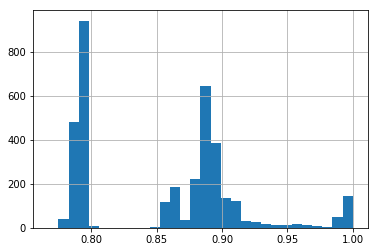

In [11]:
new_train['ratio'].hist(bins=30)

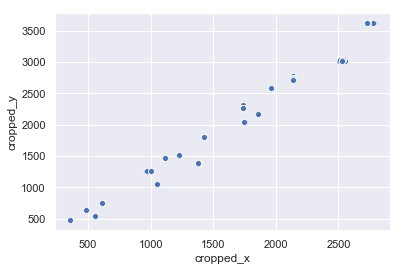

In [24]:
ax = sns.scatterplot(x="cropped_x", y="cropped_y", data=new_train)

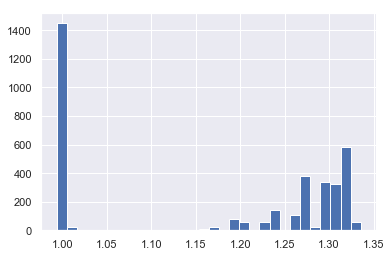

In [6]:
(new_train['cropped_y']/new_train['cropped_x']).hist(bins=30)

#### test

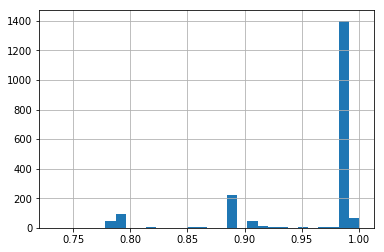

In [20]:
new_test['ratio'].hist(bins=30)

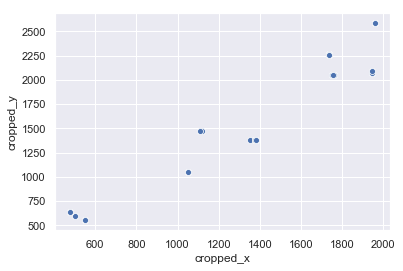

In [26]:
ax = sns.scatterplot(x="cropped_x", y="cropped_y", data=new_test)

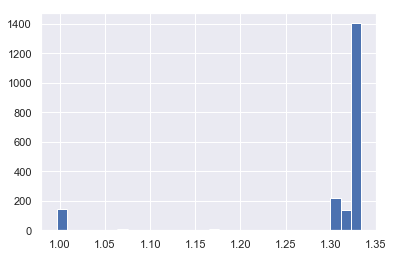

In [7]:
(new_test['cropped_y']/new_test['cropped_x']).hist(bins=30)

#### 2015

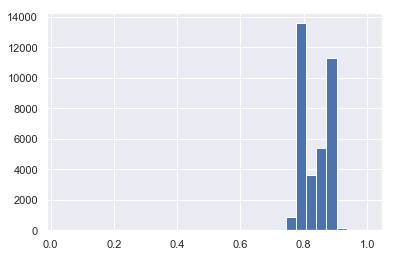

In [31]:
new_train_old['ratio'].hist(bins=30)

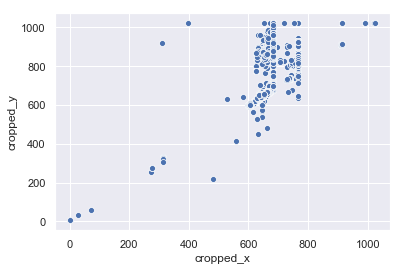

In [32]:
ax = sns.scatterplot(x="cropped_x", y="cropped_y", data=new_train_old)

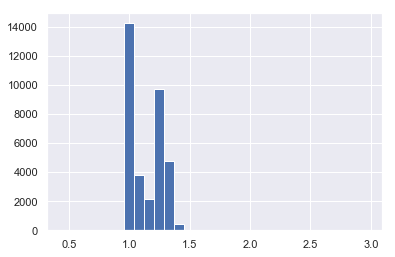

In [8]:
(new_train_old['cropped_y']/new_train_old['cropped_x']).hist(bins=30)

## What's happend?
We now find that there is some interesting features of each data.

In [28]:
new_train_old.describe()

,level,x,y,cropped_x,cropped_y,ratio
count,35126.000000,35126.000000,35126.000000,35126.000000,35126.000000,35126.000000
mean,0.526049,702.352929,1023.628822,686.663383,782.441212,0.831286
std,0.970390,39.767900,15.178057,51.103595,115.262956,0.047694
min,0.000000,289.000000,400.000000,3.000000,5.000000,0.038387
25%,0.000000,683.000000,1024.000000,651.000000,653.000000,0.785555
50%,0.000000,683.000000,1024.000000,683.000000,831.000000,0.826389
75%,1.000000,683.000000,1024.000000,683.000000,878.000000,0.876936
max,4.000000,1024.000000,1024.000000,1024.000000,1024.000000,0.999995


In [21]:
new_train_old[new_train_old['ratio']<0.75].head(10)

,Unnamed: 0,image,level,x,y,cropped_x,cropped_y,ratio
424,424,492_left,0,768.0,1024.0,764.0,1024.0,0.668773
425,425,492_right,0,768.0,1024.0,310.0,920.0,0.712433
462,462,551_left,0,683.0,1024.0,683.0,821.0,0.624500
510,510,622_left,0,768.0,1024.0,768.0,897.0,0.573069
546,546,669_left,0,768.0,1024.0,727.0,731.0,0.559769
632,632,766_left,1,768.0,1024.0,557.0,414.0,0.123965
764,764,940_left,0,768.0,1024.0,768.0,831.0,0.745561
1188,1188,1475_left,2,768.0,1024.0,768.0,824.0,0.634266
1264,1264,1557_left,0,768.0,1024.0,761.0,823.0,0.676918
1334,1334,1659_left,0,768.0,1024.0,768.0,870.0,0.643531


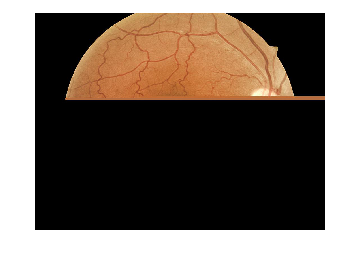

In [28]:
x = '492_right'
im =Image.open(f'../input/diabetic-retinopathy-resized/resized_train/{x}.jpeg')
ax = plt.imshow(im)
ax = plt.axis('off')

2015のデータの分布は特徴的
* 横長の画像が多い
* 光量が足りずに背景と同化している画像もある

In [6]:
df = new_train_old[new_train_old['ratio']>=0.75]
df = df[df['cropped_y']/df['cropped_x'] <= 4/3]
df[['image','level']].to_csv('../input/diabetic-retinopathy-resized/new_trainLabels.csv')

In [7]:
df = pd.read_csv('../input/diabetic-retinopathy-resized/new_trainLabels.csv')
X = np.array(df['image']).reshape(-1,1)
y = df['level']

In [13]:
from imblearn.over_sampling import RandomOverSampler
dic = {0:24711,1:4800,2:12000,3:3000,4:8000}
ros = RandomOverSampler(sampling_strategy = dic,random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [14]:
df = pd.DataFrame()
df['image'] = X_resampled.reshape(-1)
df['level'] = y_resampled

In [16]:
df.to_csv('../input/diabetic-retinopathy-resized/balanced_trainLabels.csv')

In [15]:
df['level'].value_counts()

0    24711
2    12000
4     8000
1     4800
3     3000
Name: level, dtype: int64

In [6]:
new_train['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [3]:
df=pd.read_csv('../input/diabetic-retinopathy-resized/balanced_trainLabels.csv')

In [8]:
df[df['level']==2]['image'].nunique()

5050

In [ ]:
d